## Ансамбли. Бустинг

### ЗАДАНИЕ I. ДОПОЛНИТЕЛЬНОЕ

Дано: набор данных из системы поискового антиспама.

Требуется: сравнить классификаторы, основанные на алгоритмических композициях, с классическими алгоритмами классификации и нейросетями.

1. Скачать данные и запустить шаблон кода на python:

```
$ python compos.py -h
$ python compos.py -tr spam.train.txt -te spam.test.txt
```
2. Подобрать параметры трёх алгоритмических композиций, чтобы они превосходили по качеству SVM, логистическую регрессию и двуслойный персептрон.

3. Построить графики качества классификации в зависимости от числа базовых моделей.

In [1]:
!python compos.py -h
!python compos.py -tr spam.train.txt -te spam.test.txt

usage: compos.py [-h] [-tr TRAIN] [-te TEST] [-t TREES] [-fp FEATURES_PERCENT]

Random Forest Tutorial

optional arguments:
  -h, --help            show this help message and exit
  -tr TRAIN, --train TRAIN
                        Train file name
  -te TEST, --test TEST
                        Test file name
  -t TREES, --trees TREES
                        Number of trees in random forest
  -fp FEATURES_PERCENT, --features_percent FEATURES_PERCENT
                        Percent of features in each tree
Build random forest classifier...
Build adaboost classifier...
Build gbm classifier...
Build svm classifier...
Random Forest :
             precision    recall  f1-score   support

        0.0    0.57718   0.75406   0.65387      2033
        1.0    0.93243   0.86003   0.89477      8023

avg / total    0.86061   0.83860   0.84607     10056
final score    0.75481   0.80704   0.77432     10056

AdaBoost :
             precision    recall  f1-score   support

        0.0    0.92398   0.424

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [2]:
train_data = np.loadtxt("spam.train.txt")
test_data  = np.loadtxt("spam.test.txt")

X_train, y_train = train_data[0::, 1::], train_data[0::, 0]
X_test, y_test = test_data[0::, 1::], test_data[0::, 0]

In [4]:
X_train.shape

(7093, 102)

In [5]:
svm_classifier = svm.SVC()
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
f1_score(y_test, y_pred)

0.9585241566148487

In [6]:
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)
y_pred = logreg_classifier.predict(X_test)
f1_score(y_test, y_pred)

/Users/anastasiabogatenkova/miniconda3/envs/sphere/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9354754098360656

In [48]:
import torch
from torch.nn import MSELoss, Linear, Sigmoid, Module

class Net(Module):
    def __init__(self, activation=Sigmoid(), latent_size=100):
        super().__init__()
        self.fc1 = Linear(102, latent_size)
        self.fc2 = Linear(latent_size, 1)
        self.activation = activation
    def forward(self, x):
        return self.fc2(self.activation(self.fc1(x)))
    
def train(network, X_train, y_train, epochs=200, learning_rate=0.01, loss=MSELoss(), optim=torch.optim.Adam):
    optimizer = optim(network.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = network(X_train)
        loss_value = loss(y_pred, y_train)
        loss_value.backward()
        optimizer.step()

In [49]:
perceptron = Net()
train(perceptron, torch.from_numpy(X_train).float(), torch.from_numpy(y_train[:,np.newaxis]).float())
y_pred = perceptron(torch.from_numpy(X_test).float())
f1_score(y_test[:,np.newaxis], (y_pred.detach().numpy() > 0.5).astype(int))

0.940163132137031

In [69]:
params = list(range(50, 1001, 50)) # n_estimators

def tune_n_estimators(clf, X_train, y_train):
    best_n_estimators = params[0]
    res_score = 0
    scores = []

    for n_estimators in params:
        clf = clf.set_params(**{'n_estimators': n_estimators})
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = f1_score(y_test, y_pred)
        scores.append(score)
        if score > res_score:
            best_n_estimators = n_estimators
            res_score = score
    return scores, res_score, best_n_estimators

def make_plot(scores, clf_name):
    plt.figure(figsize=(15, 5))
    plt.title('Parameters tuning for ' + clf_name)
    plt.xlabel('n_estimators')
    plt.ylabel('F1-score')
    plt.tick_params(axis='x', labelrotation=90)
    plt.plot(params, scores)

F1-score=0.9679426141052497, n_estimators=900


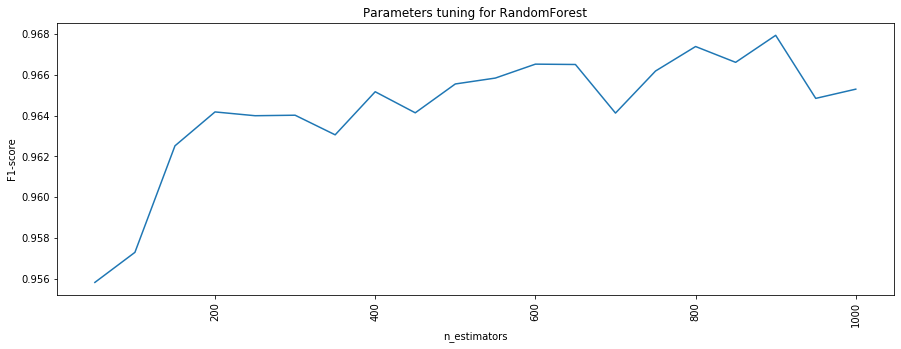

In [70]:
forest = RandomForestClassifier()
scores, res_score, best_n_estimators = tune_n_estimators(forest, X_train, y_train)
print(f'F1-score={res_score}, n_estimators={best_n_estimators}')
make_plot(scores, 'RandomForest')

F1-score=0.9599457727384767, n_estimators=150


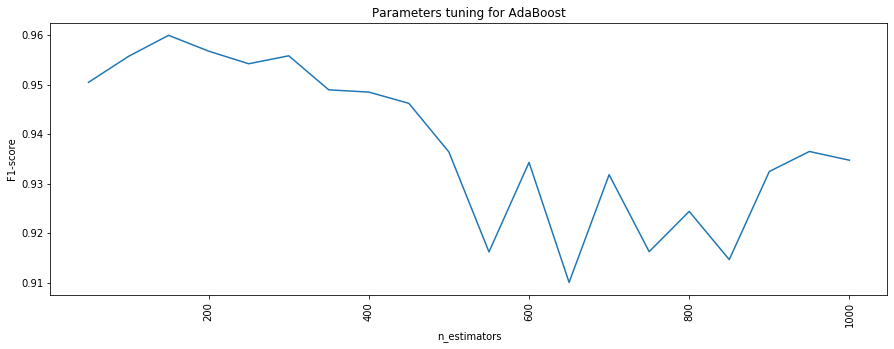

In [71]:
adaboost_classifier = AdaBoostClassifier()
scores, res_score, best_n_estimators = tune_n_estimators(adaboost_classifier, X_train, y_train)
print(f'F1-score={res_score}, n_estimators={best_n_estimators}')
make_plot(scores, 'AdaBoost')

F1-score=0.975473107569721, n_estimators=250


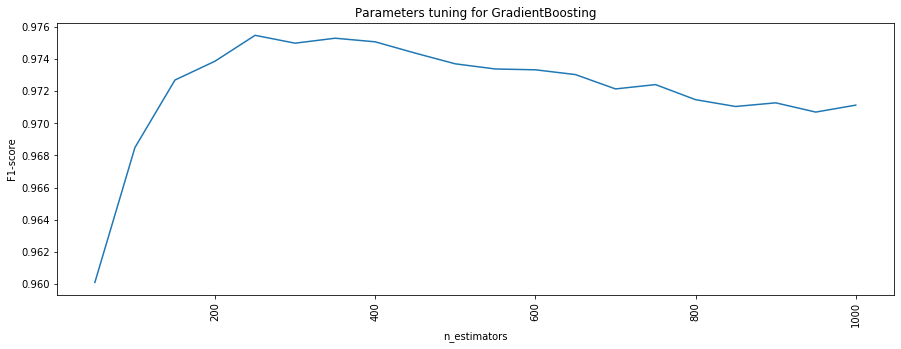

In [72]:
gbm_classifier = GradientBoostingClassifier()
scores, res_score, best_n_estimators = tune_n_estimators(gbm_classifier, X_train, y_train)
print(f'F1-score={res_score}, n_estimators={best_n_estimators}')
make_plot(scores, 'GradientBoosting')

### ЗАДАНИЕ II. ОСНОВНОЕ

Что необходимо сделать: реализовать один из алгоритмов машинного обучения, являющегося композицией алгоритмов.

In [8]:
def ComputeMyTaskNumber(your_name):
    return 1 + hash(your_name) % 21
ComputeMyTaskNumber('Bogatenkova_Anastasiya')

7

Вариант 7: Реализация алгоритма BagBoo. В качестве базового алгоритма использовать алгоритм градиентного бустинга с логистической функцией потерь.

### Descision Tree Regressor

In [3]:
class Node:
    def __init__(self, depth, max_depth, is_leaf=False):
        self.is_leaf = is_leaf
        self.depth = depth
        self.max_depth = max_depth
        
    @staticmethod
    def _intersection(s1, s2):
        s = set(s2)
        return np.array(list(filter(lambda x: x in s, s1)))
        
    @staticmethod
    def _mse(y):
        return np.var(y) * y.shape[0]
        
    def _stopping_criteria(self, X, y):
        if self.max_depth is not None and self.depth >= self.max_depth:
            return True
        return False
    
    def _get_impurity_change(self, y, y_left, y_right):
        return self._mse(y) - self._mse(y_left) * y_left.shape[0] / y.shape[0] - self._mse(y_right) * y_right.shape[0] / y.shape[0]
        
    def _get_predicate(self, X, y, table, indices):
        best_feature, best_threshold, best_impurity, best_index = None, None, None, None
        for feature in np.arange(X.shape[1]):
            sum_left, sum_right = 0, np.sum(y[indices])                
            table_feature = self._intersection(table[feature], indices)
            n = table_feature.shape[0]
            
            for ind, k in enumerate(table_feature[:-1]):
                sum_left += y[k]
                sum_right -= y[k]
                new_impurity = -sum_left**2 / float(ind + 1) - sum_right**2 / float(n - ind - 1)

                if X[table_feature[ind + 1], feature] > X[k, feature]:
                    
                    if best_feature is None or new_impurity < best_impurity:
                        threshold = (X[k, feature] + X[table_feature[ind + 1], feature]) / 2.
                        best_feature = feature
                        best_threshold = threshold
                        best_impurity = new_impurity
                        best_index = ind + 1                        
                
        if best_feature is not None:
            table_feature = self._intersection(table[best_feature], indices)
            best_left  = table_feature[:best_index]
            best_right = table_feature[best_index:]          
            self.var_importance = len(indices) * self._get_impurity_change(y[indices], y[best_left], y[best_right]) / X.shape[0]
        else:
            best_left  = None
            best_right = None        
        return best_feature, best_threshold, best_left, best_right
        
    def fit(self, X, y, table, indices):
        if self._stopping_criteria(X[indices], y[indices]):
            self.is_leaf = True
            self.answer = np.mean(y[indices])
            return
        self.feature, self.threshold, left, right = self._get_predicate(X, y, table, indices)
        if self.feature is None:
            self.is_leaf = True
            self.answer = np.mean(y[indices])            
            return

        self.left = Node(self.depth + 1, max_depth=self.max_depth)
        self.left.fit(X, y, table, left)
        self.right = Node(self.depth + 1, max_depth=self.max_depth)
        self.right.fit(X, y, table, right)
    
    def predict(self, X):
        if self.is_leaf:
            return self.answer
        else:
            if X[self.feature] <= self.threshold:
                return self.left.predict(X)
            else:
                return self.right.predict(X)
        
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
    
    def fit(self, X, y):
        table = X.argsort(axis=0).T
        indices = np.arange(X.shape[0])
        self.root = Node(0, max_depth=self.max_depth)                
        self.root.fit(X, y, table, indices)
        return self
        
    def predict(self, X):
        return np.array([self.root.predict(x) for x in X])

In [4]:
from sklearn.metrics import mean_squared_error

myclf = DecisionTree(max_depth=1)
myclf.fit(X_train, y_train)
y_pred = myclf.predict(X_test)
mean_squared_error(y_test, y_pred)

0.12446198984602179

In [5]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(max_depth=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_squared_error(y_test, y_pred)

0.12446198984602179

### Gradient Boosting

In [6]:
N_ESTIMATORS = 500

In [7]:
class GradientBoosting:
    def __init__(self, learning_rate=0.1,
                 n_estimators=100,
                 max_depth=3,
                 base_estimator=DecisionTreeRegressor):

        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.base_estimator = base_estimator
        self.estimators = [None] * self.n_estimators
        self.weights = []
        self.train_pred_ = []
        
    @staticmethod
    def _sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def _loss(y_true, y_pred):
        # deviance = 2 * negative log-likelihood according to sklearn
        return -2 * np.mean((y_true * y_pred) - np.logaddexp(0, y_pred))

    @staticmethod
    def _negative_gradient(y_true, y_pred):
        # - y*log(sigma(x)) - (1-y)*log(1-sigma(x))
        # sigma(x)' = sigma(x) * (1 - sigma(x))
        # dL/dx = - y*sigma*(1-sigma)/sigma + (1-y)(1-sigma)/sigma*(1-sigma) = sigma(x) - y
        return 2 * (y_true - GradientBoosting._sigmoid(y_pred))

    def _bi(self, y, a, h):
        # Newton method for loss minimization
        # sigma(x) = 1 / (1 + exp(-(h+b*a)))
        # dx/db = (h+b*a)' = a
        # f = dL/db = a * (sigma(x) - y)
        # f' = (a * (sigma(x) - y))' = a^2 * sigma*(1-sigma)
        b = 0
        while True:
            z = h + b * a
            sigmoid = self._sigmoid(z)
            f = np.mean(a * (sigmoid - y))
            dfdb = np.mean(np.power(a, 2) * sigmoid * (1 - sigmoid))
            b = b - f / dfdb
            if np.abs(f) < 1e-3: 
                break
        return b
    
    def _get_class(self, p):
        return np.where(p < 0.5, 0, 1)

    def fit(self, X, y):
        y_pred = np.zeros(y.shape[0])
        for i in range(self.n_estimators):             
            gi = self._negative_gradient(y, y_pred)
            self.estimators[i] = self.base_estimator(max_depth=self.max_depth).fit(X, gi)
            y_pred_new = self.estimators[i].predict(X)
            weight = self._bi(y, y_pred_new, y_pred) * self.learning_rate
            self.weights.append(weight)
            y_pred = y_pred + y_pred_new * weight
            self.train_pred_.append(y_pred)
        return self

    def predict(self, X):
        predict = np.zeros(X.shape[0])
        for i, model in enumerate(self.estimators):
            predict = predict + model.predict(X) * self.weights[i]
        return self._get_class(self._sigmoid(predict))
     
    def staged_decision_function(self, X):
        predicts = []
        predict = np.zeros(X.shape[0])
        for i, model in enumerate(self.estimators):
            predict = predict + model.predict(X) * self.weights[i]
            predicts.append(predict)
        return predicts

In [8]:
myclf = GradientBoosting(learning_rate=0.1, n_estimators=N_ESTIMATORS, 
                         base_estimator=DecisionTree, max_depth=1)
myclf.fit(X_train, y_train)
y_pred = myclf.predict(X_test)
f1_score(y_test, y_pred)

0.9696080229927231

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=N_ESTIMATORS, 
                                 max_depth=1, criterion='mse')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred)

0.9697935175540715

sklearn last train loss = 0.1882
threshold 3% = 0.1826..0.1939
my last train loss = 0.1866


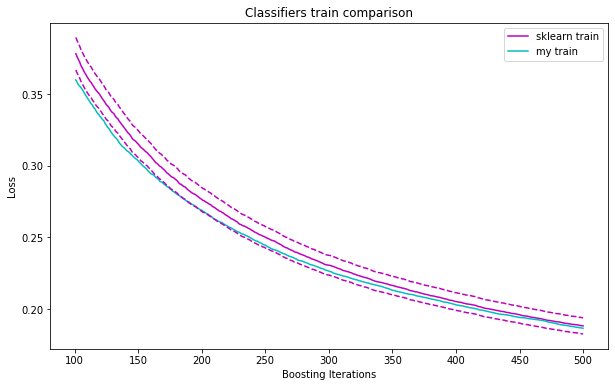

In [10]:
plt.figure(figsize=(10, 6))
plt.title('Classifiers train comparison')
START = 100
train_score_ = [myclf._loss(y_train, y_pred) for y_pred in myclf.train_pred_]
plt.plot(np.arange(N_ESTIMATORS - START) + 1 + START, clf.train_score_[START:], 'm-', label='sklearn train')
plt.plot(np.arange(N_ESTIMATORS - START) + 1 + START, train_score_[START:], 'c-', label='my train')
plt.plot(np.arange(N_ESTIMATORS - START) + 1 + START,[x * 1.03 for x in clf.train_score_[START:]], 'm-', linestyle='--')
plt.plot(np.arange(N_ESTIMATORS - START) + 1 + START,[x * 0.97 for x in clf.train_score_[START:]], 'm-', linestyle='--')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
print(f"sklearn last train loss = {clf.train_score_[-1]:.4f}")
print(f"threshold 3% = {0.97 * clf.train_score_[-1]:.4f}..{1.03 * clf.train_score_[-1]:.4f}")
print(f"my last train loss = {train_score_[-1]:.4f}")

sklearn last test loss = 0.3049
threshold 3% = 0.2958..0.3141
my last test loss = 0.2998


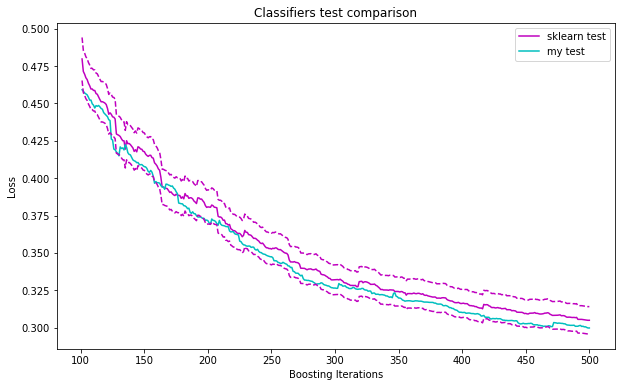

In [11]:
base_test_score = np.zeros(N_ESTIMATORS)
my_test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    base_test_score[i] = clf.loss_(y_test, y_pred)
for i, y_pred in enumerate(myclf.staged_decision_function(X_test)):
    my_test_score[i] = myclf._loss(y_test, y_pred)

START = 100
plt.figure(figsize=(10, 6))
plt.title('Classifiers test comparison')
plt.plot(np.arange(N_ESTIMATORS - START) + 1 + START, base_test_score[START:], 'm-', label='sklearn test')
plt.plot(np.arange(N_ESTIMATORS - START) + 1 + START, my_test_score[START:], 'c-', label='my test')
plt.plot(np.arange(N_ESTIMATORS - START) + 1 + START, [x * 1.03 for x in base_test_score[START:]], 'm-', linestyle='--')
plt.plot(np.arange(N_ESTIMATORS - START) + 1 + START, [x * 0.97 for x in base_test_score[START:]], 'm-', linestyle='--')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')

print(f"sklearn last test loss = {base_test_score[-1]:.4f}")
print(f"threshold 3% = {0.97 * base_test_score[-1]:.4f}..{1.03 * base_test_score[-1]:.4f}")
print(f"my last test loss = {my_test_score[-1]:.4f}")

### Bagging of Boostings

In [12]:
from scipy import stats

class BagBoo:
    
    def __init__(self, n_estimators=10, max_samples=1.0, max_features=1.0):
        """
        max_samples: float, proportion of samples to draw from X to train each base estimator
        max_features: float, proportion of features to draw from X to train each base estimator
        """
        self.n_estimators = n_estimators
        self.estimators = [GradientBoosting() for i in range(self.n_estimators)]
        self.max_samples = max_samples
        self.max_features = max_features
        self.features_ids_list = []
    
    def fit(self, X_train, y_train):
        samples_num = int(self.max_samples * X_train.shape[0])
        features_num = int(self.max_features * X_train.shape[1])
        for estimator in self.estimators:
            samples_ids = np.random.choice(X_train.shape[0], samples_num, replace=True)
            features_ids = np.random.choice(X_train.shape[1], features_num, replace=False)
            self.features_ids_list.append(features_ids)
            estimator.fit(X_train[samples_ids][:, features_ids], y_train[samples_ids])
        
    def predict(self, X_test):
        predictions = []
        for i in range(self.n_estimators):
            predictions.append(self.estimators[i].predict(X_test[:,self.features_ids_list[i]]))
        return stats.mode(predictions)[0][0]

In [13]:
bagboo = BagBoo(n_estimators=10, max_samples=0.7)
bagboo.fit(X_train, y_train)
y_pred = bagboo.predict(X_test)
f1_score(y_test, y_pred)

0.9730441323971915

In [14]:
from sklearn.ensemble import BaggingClassifier

bagboo_sklearn = BaggingClassifier(base_estimator=GradientBoostingClassifier(), n_estimators=10, max_samples=0.7)
bagboo_sklearn.fit(X_train, y_train)
y_pred = bagboo_sklearn.predict(X_test)
f1_score(y_test, y_pred)

0.9750218558761083